# RANDOM FORESTS

In [1]:
from fastai.imports import *
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=130)

In [2]:
df = pd.read_csv('train.csv')
tst_df = pd.read_csv('test.csv')
modes = df.mode().iloc[0]

In [3]:
df.mode().iloc[0]

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [4]:
def proc_data(df):#processing the data
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df['Embarked'])
    df['Sex'] = pd.Categorical(df['Sex'])

proc_data(df)
proc_data(tst_df)

In [5]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [6]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [7]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S,2.639057
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,3.433987
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S,3.196630
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3.433987


## Binary splits - A random forest is a ensemble of trees and a tree is a ensemble of binary splits

In [8]:
import seaborn as sns

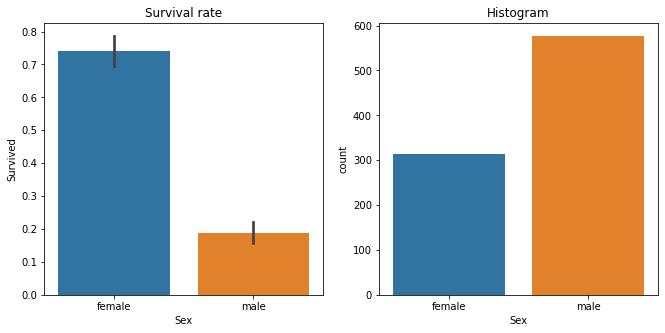

In [9]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");#WE CAN SEE THAT SURVIVAL RATES OF MALE AND FEMALES ARE VERY DIFFERENT 

In [10]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)#SPLTTING INTO TRAINING AND TEST SETS USING SCIKIT LEARN 
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)#CONVERTING ALL CATEGORICAL VARIABLES INTO THERE CODES
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [11]:
def xs_y(df):#RETURNS THE INDEPENDENT AND DEPENDENT VARIABLES
    xs = df[cats+conts].copy() #CATEGORICAL PLUS CONSTANT VARIABLES GIVE INDEPENDENT VARIABLES OR X 
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)#train
val_xs,val_y = xs_y(val_df)#validation 

In [12]:
copy?

In [13]:
preds = val_xs.Sex==0 #preds value true if they are female

In [14]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y,preds)

0.21524663677130046

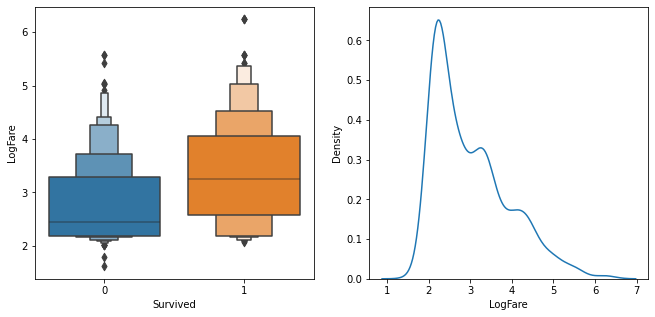

In [15]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

In [16]:
preds = val_xs.LogFare>2.7 #trying to predict using fares distribution

In [17]:
mean_absolute_error(val_y, preds) #worse error

0.336322869955157

In [18]:
def _side_score(side, y): #to find a score  how good of a binary split it is whether it is categorical or continous or whatever data 
    tot = side.sum() # a good split is in which all of the dependent variables on one side are all pretty much the same, if all the males have the same out come that is did not survive and all the females have the same outcome that is did survive then that is a good split
    if tot<=1: return 0
    return y[side].std()*tot#multiplied by the number of count in that group

In [19]:
def score(col, y, split): 
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)#lhs+rhs

In [20]:
score(trn_xs["Sex"], trn_y, 0.5)

0.4078753098206398

In [21]:
score(trn_xs["LogFare"], trn_y, 0.5) #lower score is better

0.4828257748854045

In [22]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [23]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

In [24]:
#to automate the above 2 cells

In [25]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()#take all the unq values of age and try each one
unq.sort()

In [26]:
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [27]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]#find the minimum one(gives index)

6.0

In [28]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.47831671750899085)

In [29]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.4078753098206398),
 'Embarked': (0, 0.478833425731479),
 'Age': (6.0, 0.47831671750899085),
 'SibSp': (4, 0.4783740258817423),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736595),
 'Pclass': (2, 0.4604826188580666)}

In [30]:
# this is called one-r model ,one of the best classifiers , dont assume you have to go complicated 

# DESCISION TREE

In [31]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [32]:
# Now let's find the single best binary split for males
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.387558187041091),
 'Age': (6.0, 0.37398283710105873),
 'SibSp': (4, 0.38758642275862637),
 'Parch': (0, 0.3874704821461953),
 'LogFare': (2.803360380906535, 0.38048562317581447),
 'Pclass': (1, 0.3815544200436083)}

In [33]:
{o:min_col(females, o) for o in cols} #SAME FOR FEMALES # the least in this 0.3335 is the biggest factor of these that will predict whether a female will survive or not

{'Embarked': (0, 0.4295252982857326),
 'Age': (50.0, 0.4225927658431646),
 'SibSp': (4, 0.42319212059713585),
 'Parch': (3, 0.4193314500446157),
 'LogFare': (4.256321678298823, 0.413505983329114),
 'Pclass': (2, 0.3335388911567602)}

In [34]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [35]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

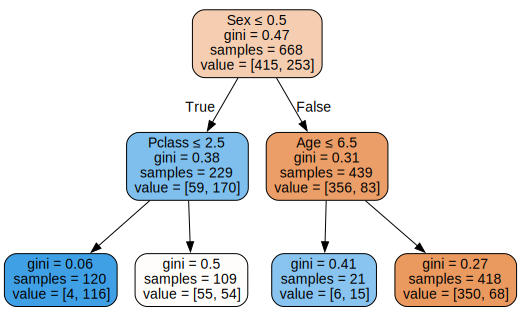

In [36]:
draw_tree(m, trn_xs, size=10)

In [37]:
#bad idea to be a adult male in titanic
#in females pclass less than 2.5 , 116 of them survived
#gini is a way to see how good the split is , lesser the gini better it is, 2nd leaf node is 5050 so it is bad
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [38]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [39]:
# for one-r error was 0.215
mean_absolute_error(val_y, m.predict(val_xs)) #loss for the descision tree with 4 leaf nodes

0.2242152466367713

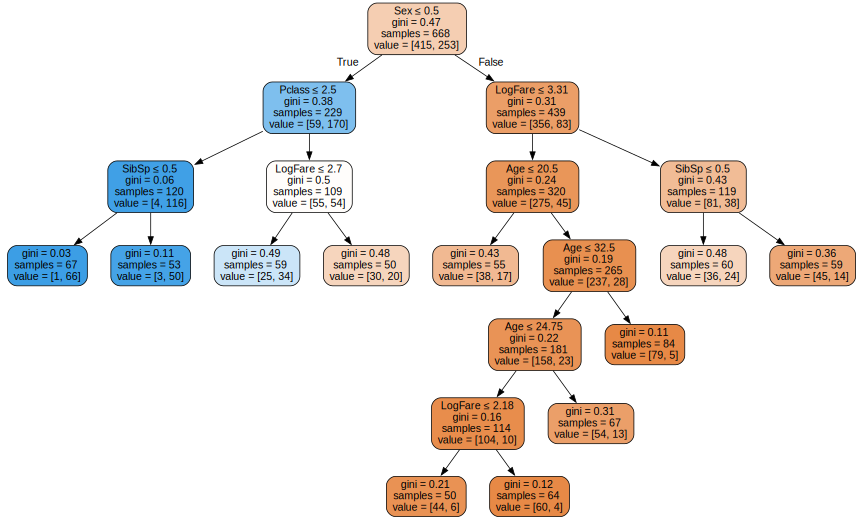

In [40]:
m = DecisionTreeClassifier(min_samples_leaf=50) #minimum of 50 values in each leaf node
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [41]:
mean_absolute_error(val_y, m.predict(val_xs)) 

0.18385650224215247

In [42]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree') #SCORE IS LIL WORSE BUT WE DID NOT HAVE TO DO MORE PREPROCESSING HARD WORK IN DECISION TREES COMPARED TO OUR LINEAR AND NEURAL NETWORK MODELS

In [43]:
#FOR TABULAR DATA DECISION TREES ARE VERY USEFUL

In [44]:
df.Embarked.head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

In [45]:
df.Embarked.cat.codes.head()

0    2
1    0
2    2
3    2
4    2
dtype: int8

### HOW TO MAKE THIS MORE ACCURATE

In [46]:
#THERE ARE LIMITS TO WHAT A DECISION TREE COULD DO
#WE CAN USE BAGGING
#LETS SAY WE ARE USING NOT SO GOOD MODEL , WE CAN USE MAKE LOTS AND LOTS OF SLIGHTLY DIFFERENT DECISION TREES THEN IF WE AVERAGE THOSE ERRORS 0 WILL COME 
#MINDBLOWING INSIGHT


### RANDOM FOREST
WE ARE CREATING BUNCH OF DECISION TREES USING DIFFERENT SUBSETS OF DATA 

In [47]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [48]:
trees = [get_tree() for t in range(100)]

In [49]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)
mean_absolute_error(val_y, avg_probs)

0.2272645739910314

In [50]:
#THIS WAS IDENTICAL TO RANDOMFOREST CLASSIFIER OF SKLEARN
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

In [51]:
subm(rf.predict(tst_xs), 'randforest') #slightly more worse but in ideal real world datasets, randomforest does a better job than single tree

In [52]:
# One particularly nice feature of random forests is they can tell us which independent variables were the most important in the model, using feature_importances_:

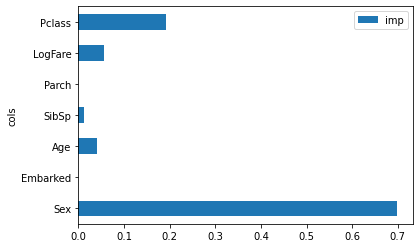

In [53]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

In [54]:
# it shows which improved the gini most, for any dataset we can find the variable which is most important

In [55]:
#having more trees always improves accuracy tiny bits not more than 100 trees 
#always start  a tabular model with random forest